In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from alg_functions import *

# Obtain the Data

In [3]:
qso_g_df = pd.read_csv('datasets/corrected_QSO_GALAXY_Dataset.csv')

qso_g_df = qso_g_df.dropna()
qso_g_df.rename(columns={'class': 'type'}, inplace=True)

galaxy_df = qso_g_df[qso_g_df['type'] == 'GALAXY'].sample(n=2000, random_state=42)
qso_df = qso_g_df[qso_g_df['type'] == 'QSO'].sample(n=2000, random_state=42)

qso_g_df = pd.concat([galaxy_df, qso_df])

display(qso_g_df.head())

,type,subclass,mag_u,mag_g,mag_r,mag_i,mag_z,redshift,flux_u,flux_g,...,flux_i,flux_z,photRA,specRA,photDec,specDec,petrosianRadius_u,deVEffectiveRadius_u,petrosianRadius_z,deVEffectiveRadius_z
4498,GALAXY,STARFORMING,20.20175,18.42369,17.36100,16.85209,16.42140,0.116623,4.067745,11.13524,...,51.35847,72.29363,218.563632,218.56364,8.992736,8.992744,2.970685,7.054471,5.191600,2.716197
3646,GALAXY,STARFORMING,19.64754,18.41117,17.75667,17.36501,17.06143,0.073963,3.827840,8.99992,...,29.52955,37.28042,339.559695,339.55971,14.157285,14.157290,43.764050,26.746740,8.903262,10.204720
4242,GALAXY,STARFORMING,19.61266,17.91331,17.00628,16.59109,16.24816,0.107316,6.293722,25.02789,...,96.43300,125.75090,120.833410,120.83341,12.104724,12.104733,8.076633,6.684969,3.399417,1.761480
2464,GALAXY,STARFORMING,18.55299,17.09966,16.39841,16.01200,15.75324,0.066666,18.779910,47.22098,...,135.92570,166.69580,180.117997,180.11801,51.756060,51.756076,5.504677,4.108453,4.365156,2.409809
8715,GALAXY,STARFORMING,16.71037,15.61988,15.25153,15.01981,14.84542,0.027207,18.918650,32.80019,...,72.02156,87.63742,158.926025,158.92608,5.615982,5.615976,17.752350,29.677330,16.224320,28.178960


In [4]:
qso_g_df['u-g'] = qso_g_df['flux_u'] - qso_g_df['flux_g']
qso_g_df['g-r'] = qso_g_df['flux_g'] - qso_g_df['flux_r']
qso_g_df['r-i'] = qso_g_df['flux_r'] - qso_g_df['flux_i']
qso_g_df['i-z'] = qso_g_df['flux_i'] - qso_g_df['flux_z']
qso_g_df['u-z'] = qso_g_df['flux_u'] - qso_g_df['flux_z']
qso_g_df['u-r'] = qso_g_df['flux_u'] - qso_g_df['flux_r']
qso_g_df['r-z'] = qso_g_df['flux_r'] - qso_g_df['flux_z']

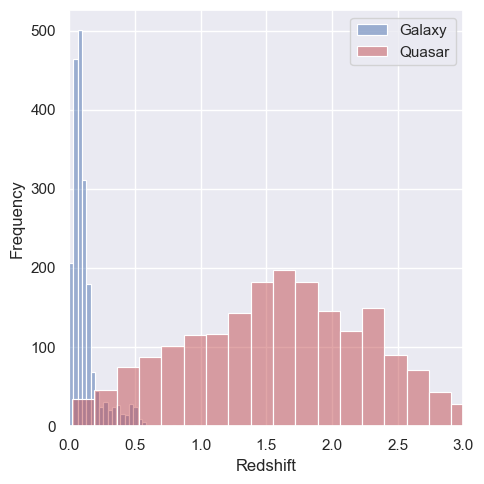

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

galaxy_df = qso_g_df[qso_g_df['type'] == 'GALAXY']
qso_df = qso_g_df[qso_g_df['type'] == 'QSO']

sns.set(style="darkgrid")

plt.figure(figsize=(5, 5))

# Plotting GALAXY redshift
sns.histplot(galaxy_df['redshift'], bins=30, color='b', alpha=0.5, label='Galaxy')

# Plotting QSO redshift
sns.histplot(qso_df['redshift'], bins=30, color='r', alpha=0.5, label='Quasar')

plt.xlim(0, 3)  # Set x-axis limit

#plt.title('Redshift Distribution in GALAXY and QSO')
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# create a scaler object
scaler = StandardScaler()

pred_columns_qso_g = ['u-z', 'u-r', 'r-z', 'redshift']

qso_g_df_norm = qso_g_df[pred_columns_qso_g]

# fit and transform the data

qso_g_df_norm = pd.DataFrame(scaler.fit_transform(qso_g_df_norm), columns = pred_columns_qso_g)

# add the 'type' column back to the normalized DataFrame
qso_g_df_norm['type'] = qso_g_df['type'].values

display(qso_g_df_norm.head())

,u-z,u-r,r-z,redshift,type
0,-0.305543,-0.156948,-0.435702,-0.815634,GALAXY
1,0.136068,0.155662,0.116330,-0.861102,GALAXY
2,-0.956166,-0.946658,-0.950819,-0.825554,GALAXY
3,-1.317584,-1.429763,-1.196716,-0.868880,GALAXY
4,-0.311803,-0.397975,-0.229181,-0.910937,GALAXY


In [7]:
train_set = qso_g_df_norm[qso_g_df_norm['type'] == 'QSO']

outliers = train_set[(np.abs(stats.zscore(train_set[pred_columns_qso_g])) > 1).all(axis=1)]
train_set = train_set[~train_set.isin(outliers)].dropna()

# Algorithm 1

In [8]:
for epsilon in [0.01, 0.001, 0.0001]:

    print('---------------')
    print('Epsilon: ', epsilon)

    # Run the Away Step Frank-Wolfe algorithm
    c, r, k, chi, timer, delta, core_size = frank_wolfe_alg_MEB(epsilon, train_set[pred_columns_qso_g].values)

    # Calculate Accuracies
    distances = np.linalg.norm(qso_g_df_norm[pred_columns_qso_g] - c, axis=1)
    qso_g_df_norm['InsideBall'] = distances < r
    print(measure_accuracy('GALAXY', 'QSO', qso_g_df_norm))

---------------
Epsilon:  0.01
Center: [ 0.08379819  0.44748363 -0.24690729  1.81358104]
Radius: 2.8105779165185036
Iterations: 7
CPU time: 0.06727814674377441
Core Set Size: 4
                Metric        Count
0   True Positive (TP)  1991.000000
1  False Negative (FN)     9.000000
2   True Negative (TN)   864.000000
3  False Positive (FP)  1136.000000
4            Precision     0.636713
5               Recall     0.995500
6             F1 Score     0.776673
---------------
Epsilon:  0.001
Center: [ 0.09023357  0.4182748  -0.20827391  1.82671998]
Radius: 2.7896281543289367
Iterations: 58
CPU time: 0.266650915145874
Core Set Size: 5
                Metric        Count
0   True Positive (TP)  1991.000000
1  False Negative (FN)     9.000000
2   True Negative (TN)  1017.000000
3  False Positive (FP)   983.000000
4            Precision     0.669469
5               Recall     0.995500
6             F1 Score     0.800563
---------------
Epsilon:  0.0001
Center: [ 0.09041035  0.40910637 -0.1

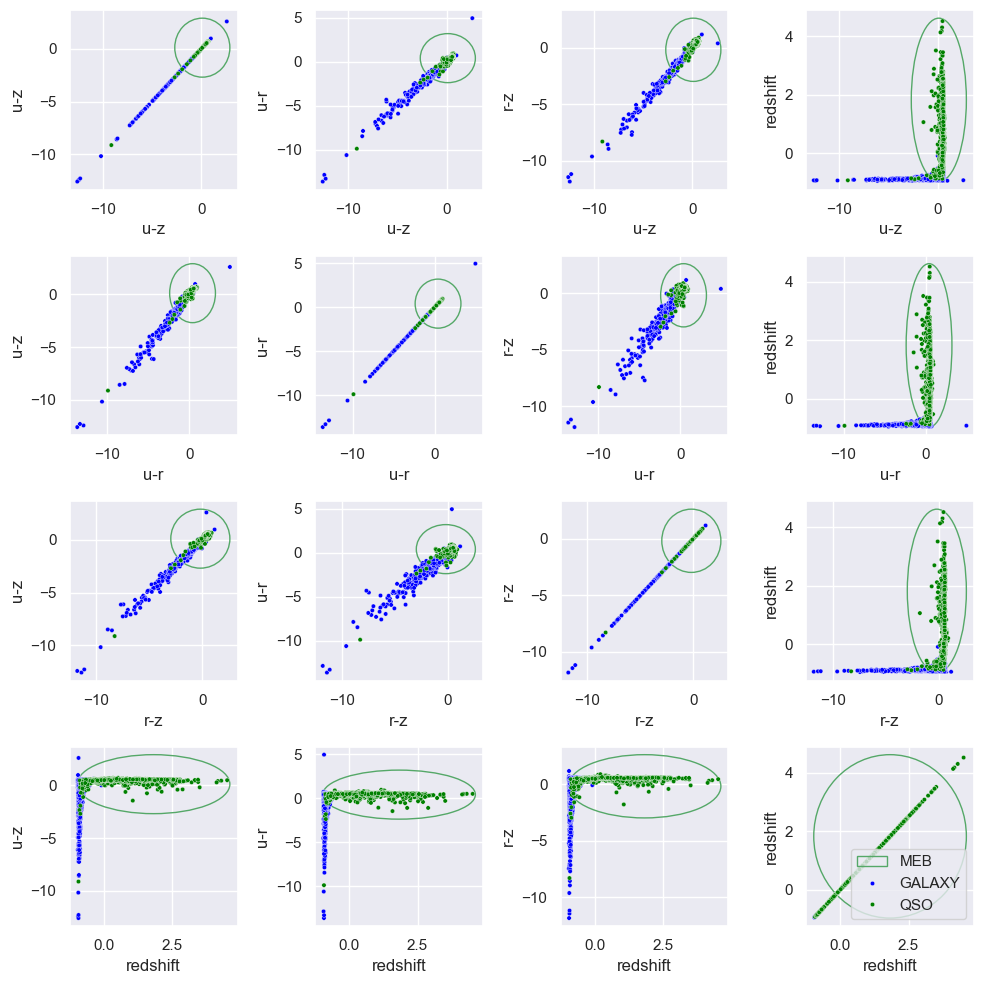

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

fig, axs = plt.subplots(len(pred_columns_qso_g), len(pred_columns_qso_g), figsize=(10, 10))

for i in range(len(pred_columns_qso_g)):
    for j in range(len(pred_columns_qso_g)):
        ax = axs[i, j]
        ax.cla()

        circle = plt.Circle(tuple(c[[i, j]]), r, color='g', fill=False, label='MEB')
        ax.add_patch(circle)

        sns.scatterplot(data=qso_g_df_norm, x=pred_columns_qso_g[i], y=pred_columns_qso_g[j], hue='type',
                        palette={'QSO': 'green', 'GALAXY': 'blue'}, s=10, ax=ax)

        ax.set_xlabel(pred_columns_qso_g[i])
        ax.set_ylabel(pred_columns_qso_g[j])

        ax.get_legend().remove()

plt.tight_layout()

plt.legend(loc='lower right')
plt.show()

# Algorithm 2

In [10]:
for epsilon in [0.01, 0.001, 0.0001]:

    print('---------------')
    print('Epsilon: ', epsilon)

    # Run the Away Step Frank-Wolfe algorithm
    center_as, radius_as, count_iterations_as, CPU_time_as, dual_val_list_as, dual_gap_list_as, core_size_as = frankWolfe_AwayStep(train_set[pred_columns_qso_g].values, epsilon)

    # Calculate Accuracies
    distances = np.linalg.norm(qso_g_df_norm[pred_columns_qso_g] - center_as, axis=1)
    qso_g_df_norm['InsideBall'] = distances < radius_as
    print(measure_accuracy('GALAXY', 'QSO', qso_g_df_norm))

---------------
Epsilon:  0.01
Center: [ 0.08715679  0.39095751 -0.18934499  1.82354058]
Radius: 2.787121768125355
Iterations: 74
CPU time: 1.7601499557495117
Set Size: 4
                Metric        Count
0   True Positive (TP)  1990.000000
1  False Negative (FN)    10.000000
2   True Negative (TN)   974.000000
3  False Positive (FP)  1026.000000
4            Precision     0.659814
5               Recall     0.995000
6             F1 Score     0.793461
---------------
Epsilon:  0.001
Center: [ 0.09005702  0.4060804  -0.19756026  1.82596892]
Radius: 2.787191820220484
Iterations: 129
CPU time: 2.9670417308807373
Set Size: 4
                Metric        Count
0   True Positive (TP)  1990.000000
1  False Negative (FN)    10.000000
2   True Negative (TN)  1011.000000
3  False Positive (FP)   989.000000
4            Precision     0.668009
5               Recall     0.995000
6             F1 Score     0.799357
---------------
Epsilon:  0.0001
Center: [ 0.09038456  0.40780796 -0.19850586  1

# Algorithm 3

In [11]:
for epsilon in [0.01, 0.001, 0.0001]:

    print('---------------')
    print('Epsilon: ', epsilon)

    # Run the Pairwise Frank-Wolfe algorithm
    center_pw, radius_pw, count_iterations_pw, CPU_time_pw, dual_val_list_pw, dual_gap_list_pw, core_size_pw = frankWolfe_Pairwise(train_set[pred_columns_qso_g].values, epsilon)

    # Calculate Accuracies
    distances = np.linalg.norm(qso_g_df_norm[pred_columns_qso_g] - center_pw, axis=1)
    qso_g_df_norm['InsideBall'] = distances < radius_pw
    print(measure_accuracy('GALAXY', 'QSO', qso_g_df_norm))

---------------
Epsilon:  0.01
Center: [ 0.08983698  0.40398949 -0.19608219  1.82539098]
Radius: 2.7871884585147226
Iterations: 41
CPU time: 0.9030327796936035
Set Size: 4
                Metric        Count
0   True Positive (TP)  1991.000000
1  False Negative (FN)     9.000000
2   True Negative (TN)  1005.000000
3  False Positive (FP)   995.000000
4            Precision     0.666778
5               Recall     0.995500
6             F1 Score     0.798636
---------------
Epsilon:  0.001
Center: [ 0.09036755  0.40762051 -0.19836821  1.82618201]
Radius: 2.7871927009215893
Iterations: 72
CPU time: 1.6656739711761475
Set Size: 4
                Metric        Count
0   True Positive (TP)  1991.000000
1  False Negative (FN)     9.000000
2   True Negative (TN)  1014.000000
3  False Positive (FP)   986.000000
4            Precision     0.668794
5               Recall     0.995500
6             F1 Score     0.800080
---------------
Epsilon:  0.0001
Center: [ 0.09042402  0.40798528 -0.19859186  

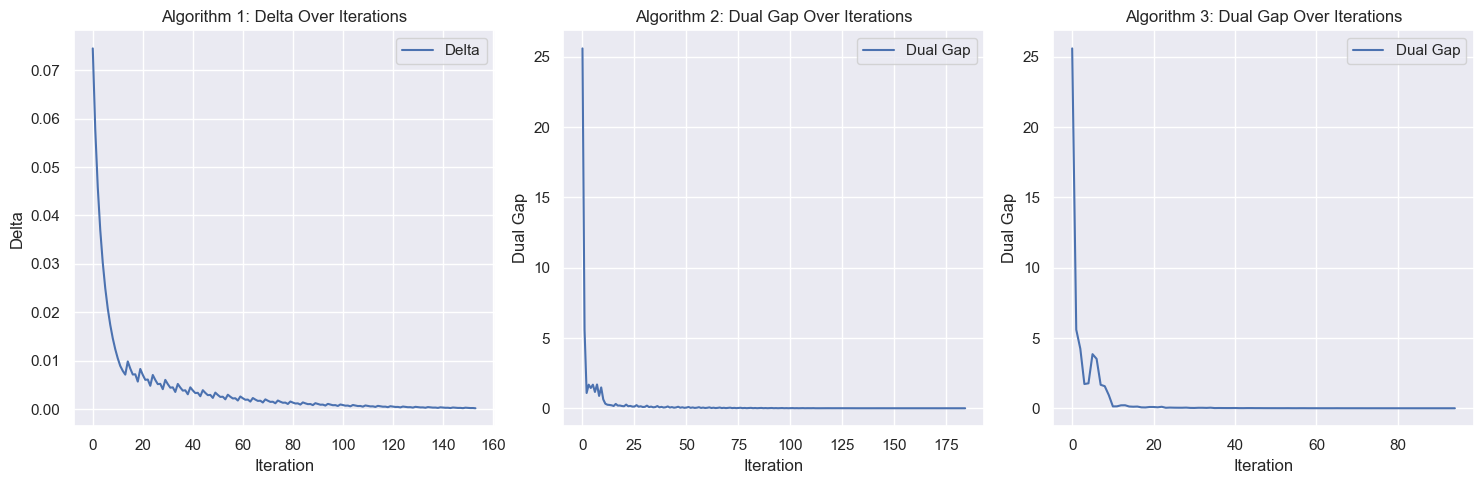

In [12]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.lineplot(ax=axs[0], data=delta, color='b', label='Delta')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Delta')
axs[0].set_title('Algorithm 1: Delta Over Iterations')

sns.lineplot(ax=axs[1], data=dual_gap_list_as, color='b', label='Dual Gap')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Dual Gap')
axs[1].set_title('Algorithm 2: Dual Gap Over Iterations')

sns.lineplot(ax=axs[2], data=dual_gap_list_pw, color='b', label='Dual Gap')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Dual Gap')
axs[2].set_title('Algorithm 3: Dual Gap Over Iterations')

plt.tight_layout()
plt.show()

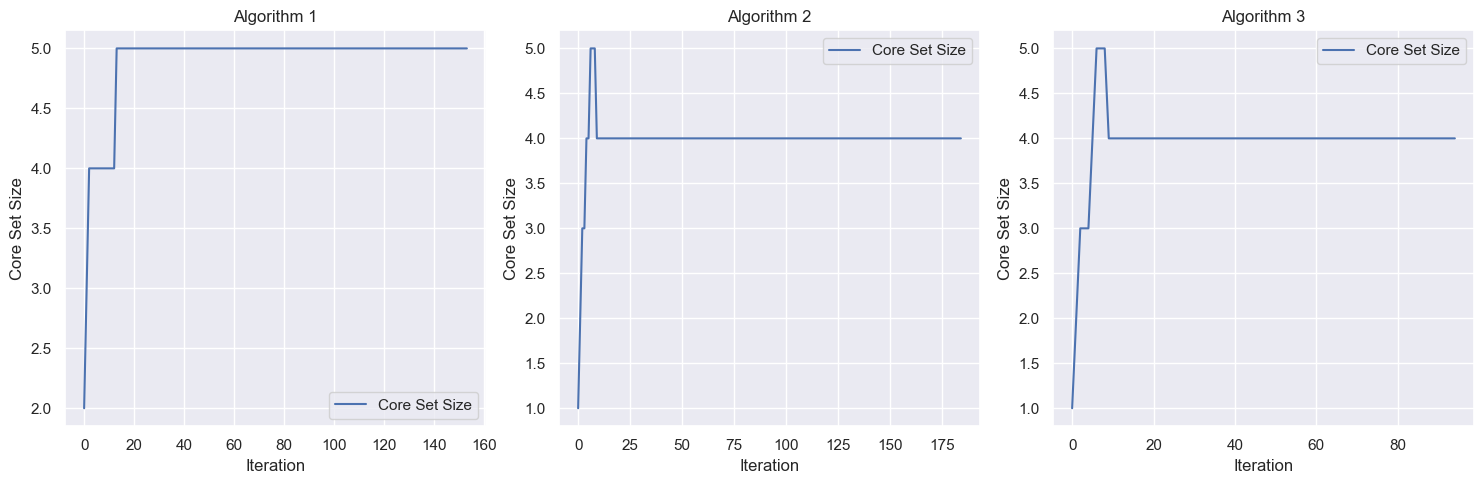

In [13]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.lineplot(ax=axs[0], data=core_size, color='b', label='Core Set Size')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Core Set Size')
axs[0].set_title('Algorithm 1')

sns.lineplot(ax=axs[1], data=core_size_as, color='b', label='Core Set Size')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Core Set Size')
axs[1].set_title('Algorithm 2')

sns.lineplot(ax=axs[2], data=core_size_pw, color='b', label='Core Set Size')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Core Set Size')
axs[2].set_title('Algorithm 3')

plt.tight_layout()
plt.show()